##1. Importamos librerías y montamos drive

In [29]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras


#Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import initializers
from keras.utils.vis_utils import plot_model
from keras.layers import BatchNormalization, Dropout
from keras.layers.core import Activation
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
import pickle

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1.1Establecemos el path del drive

In [31]:
path = "/content/drive/MyDrive/Práctica-1.1/"

##3. Cargamos los datos ya preprocesados

In [32]:
atributos = '60'

# datos_limpios_x = pd.read_csv(path + 'FootballPlayerPreparedCleanAttributes.csv')
# datos_limpios_y = pd.read_csv(path + 'FootballPlayerOneHotEncodedClasses.csv')

datos_limpios_x = pd.read_csv(path + 'Preprocesado/atributos'+atributos+'.csv')
datos_limpios_y = pd.read_csv(path + 'Preprocesado/etiquetas'+atributos+'.csv')

print(datos_limpios_x.shape, datos_limpios_y.shape)
datos_limpios_x[:5], datos_limpios_y[:5]

(16122, 6) (16122, 4)


(   Potential     Value  ShortPassing  BallControl  Reactions  Composure
 0   0.148936 -0.985232      0.315068     0.239437   0.120000   0.189189
 1  -0.021277 -0.962869      0.369863     0.295775   0.306667   0.162162
 2   0.489362 -0.805907      0.643836     0.408451   0.466667   0.243243
 3   0.191489 -0.942616     -0.041096    -0.098592   0.146667   0.135135
 4  -0.319149 -0.993671      0.232877     0.098592   0.120000   0.081081,
    Poor:[46.0, 62.0]  ...  Excel:[72.0, 94.0]
 0                0.0  ...                 0.0
 1                0.0  ...                 0.0
 2                0.0  ...                 1.0
 3                0.0  ...                 1.0
 4                0.0  ...                 0.0
 
 [5 rows x 4 columns])

##4. División de datos


1.   80% Entrenamiento
2.   10% Desarrollo
3.   10% Test



In [33]:
train = int(datos_limpios_x.shape[0]*0.8)
test = dev = int((datos_limpios_x.shape[0]-train)/2)

train_x = datos_limpios_x[:train]
train_y = datos_limpios_y[:train]

dev_x   = datos_limpios_x[train:train+dev]
dev_y   = datos_limpios_y[train:train+dev]

print('Entrenamiento : train_x: ', train_x.shape, ' | train_y: ', train_y.shape)
print('Desarrollo    : dev_x:   ', dev_x.shape, ' | dev_y:    ', dev_y.shape)

Entrenamiento : train_x:  (12897, 6)  | train_y:  (12897, 4)
Desarrollo    : dev_x:    (1612, 6)  | dev_y:     (1612, 4)


##5.Establecemiento de hiperparámetros

5.1-Creamos carpeta para guardar un informe de el modelo

In [34]:
import os
from datetime import datetime

now = datetime.now()
dt_string = now.strftime("%d_%m-%H_%M")

dir_name = "modelo"+dt_string+'_atr'+atributos
res_path = path + "Modelos/1Jorge/" + dir_name + "/"
if not os.path.isdir(res_path):
  os.mkdir(res_path)
  print("Created")
else:
  print("Dir already exists")

Created


5.2-Establecemos la configuración del modelo

In [35]:
#Hiperparametros
nombre_modelo = dir_name
n_epochs = 1000
learning_rate = 'adaptive'
initial_lr = 0.2
d_rate = 0.9
batch_size = 256
patience_value = 100

#Parametros del modelo
n_neurons_per_hlayer = [200, 80, 60, 40, 20, 10]
act_ints = len(n_neurons_per_hlayer)*['relu']
act_out = 'softmax'
dropout = 0
BatchN  = 1
L2      = '0.0001'

5.3-Lo guardamos en un dataframe para vocarlo en un excel y saber que configuración se ha creado


In [36]:
data = {'Epocas': n_epochs, 
        'LR' : learning_rate,
        'Batch' : batch_size, 
        'Neuronas_por_capa' : '['+", ".join([str(int) for int in n_neurons_per_hlayer])+']',
        'act_int' : '[' + ", ".join(act_ints) + ']', 
        'act_out': act_out,
        'Dropout': str(dropout),
        'BatchNormalization': BatchN,
        'L2': L2}

df_model_conf = pd.DataFrame(data, index = [0])
df_model_conf.index = [str(nombre_modelo)]


df_model_conf.to_excel(res_path + 'model_conf.xlsx', index=True)

if learning_rate == 'scheduled':
  learning_rate = keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate= initial_lr,
  decay_steps= n_epochs,
  decay_rate= d_rate)

##6.Construcción del modelo
Inicializadores recomendados:


1.   **RELU** --> **He** o uniforme o normal
2.   **SELU** --> **LeCun**
2.   **Sigmoid, Tanh, Softmax o no activación** --> **Xavier** tambien llamada **GlorotNormal**



In [37]:
INPUTS  = train_x.shape[1]
OUTPUTS = train_y.shape[1]


def construir_modelo(inputs=INPUTS, outputs=OUTPUTS, n_neurons_per_hlayer=n_neurons_per_hlayer):
  model = keras.Sequential(name="DeepFeedforward")
  model.add(keras.layers.InputLayer(input_shape=(INPUTS,), batch_size=None))

  for neurons, act in zip(n_neurons_per_hlayer, act_ints):
    if BatchN == 1:
      if L2 != '':          
        model.add(keras.layers.Dense(neurons, kernel_initializer=keras.initializers.he_uniform(seed=1), use_bias=False, kernel_regularizer=keras.regularizers.l2(float(L2))))
        model.add(BatchNormalization())
      else:
        model.add(keras.layers.Dense(neurons, kernel_initializer=keras.initializers.he_uniform(seed=1), use_bias=False))
        model.add(BatchNormalization())
    else:
      if L2 != '':  
        model.add(keras.layers.Dense(neurons, kernel_initializer=keras.initializers.he_uniform(seed=1), use_bias=True, kernel_regularizer=keras.regularizers.l2(L2)))
      else:
        model.add(keras.layers.Dense(neurons, kernel_initializer=keras.initializers.he_uniform(seed=1), use_bias=True))

    model.add(Activation(act))
    model.add(Dropout(rate=dropout))

  model.add(keras.layers.Dense(OUTPUTS, activation="softmax", kernel_initializer=tf.keras.initializers.GlorotNormal(seed=1)))

  if learning_rate == 'adaptive':
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
                metrics=["categorical_accuracy"])
  else:
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
            optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
            metrics=["categorical_accuracy"])
  
  return model


modelo = construir_modelo()
modelo.summary()
#plot_model(modelo, show_shapes=True, show_layer_names=True)

Model: "DeepFeedforward"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 200)               1200      
                                                                 
 batch_normalization_12 (Bat  (None, 200)              800       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 200)               0         
                                                                 
 dropout_12 (Dropout)        (None, 200)               0         
                                                                 
 dense_15 (Dense)            (None, 80)                16000     
                                                                 
 batch_normalization_13 (Bat  (None, 80)               320       
 chNormalization)                                  

##7.Entrenamiento del modelo

In [38]:
import time

path_checkpoint = res_path + nombre_modelo + ".h5"


early_stopping = EarlyStopping(monitor='val_categorical_accuracy', 
                               patience = patience_value, 
                               restore_best_weights=True)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_categorical_accuracy",
    filepath=path_checkpoint,
    save_weights_only=True,
    save_best_only=True,
    verbose=0)

ini = time.perf_counter()

history = modelo.fit(
    train_x,
    train_y,
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=(dev_x, dev_y),
    callbacks=[early_stopping, modelckpt_callback],
    verbose=2
)

fin = time.perf_counter()

Epoch 1/1000
51/51 - 2s - loss: 1.8818 - categorical_accuracy: 0.6878 - val_loss: 74.0889 - val_categorical_accuracy: 0.2692 - 2s/epoch - 40ms/step
Epoch 2/1000
51/51 - 0s - loss: 0.8581 - categorical_accuracy: 0.7421 - val_loss: 14.5845 - val_categorical_accuracy: 0.2667 - 316ms/epoch - 6ms/step
Epoch 3/1000
51/51 - 0s - loss: 0.6924 - categorical_accuracy: 0.7362 - val_loss: 12.9217 - val_categorical_accuracy: 0.2767 - 408ms/epoch - 8ms/step
Epoch 4/1000
51/51 - 0s - loss: 0.6442 - categorical_accuracy: 0.7525 - val_loss: 14.2545 - val_categorical_accuracy: 0.2587 - 313ms/epoch - 6ms/step
Epoch 5/1000
51/51 - 0s - loss: 0.6354 - categorical_accuracy: 0.7551 - val_loss: 3.5835 - val_categorical_accuracy: 0.2686 - 340ms/epoch - 7ms/step
Epoch 6/1000
51/51 - 0s - loss: 0.6388 - categorical_accuracy: 0.7484 - val_loss: 7.4219 - val_categorical_accuracy: 0.2823 - 413ms/epoch - 8ms/step
Epoch 7/1000
51/51 - 0s - loss: 0.6058 - categorical_accuracy: 0.7622 - val_loss: 2.6074 - val_categoric

###7.1 Guardado del modelo y el historial de entramiento

In [39]:
modelo.save(path_checkpoint)
with open(res_path + nombre_modelo + "history", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

##8. Evaluación del modelo sobre conjunto de desarrollo

                    Accuracy for the training set: 0.783
            Accuracy for the development test set: 0.465
Time:                                    52.377 sec


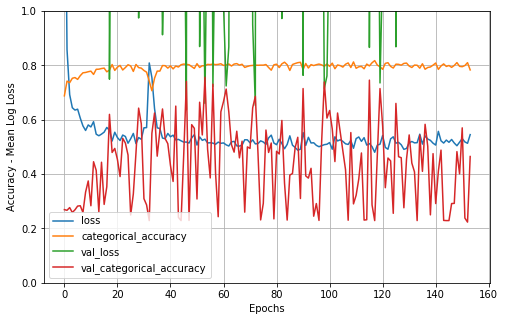

In [40]:
results=pd.DataFrame(history.history)
print(f"{'Accuracy for the training set:' : >50} {round(results.categorical_accuracy.values[-1:][0], 3)}")
print(f"{'Accuracy for the development test set:' : >50} {round(results.val_categorical_accuracy.values[-1:][0], 3)}")
print(f"{'Time:' : <40} {round(fin - ini, 3)} sec")

data = {'train_accuracy': round(results.categorical_accuracy.values[-1:][0], 3), 
        'dev_accuracy' : round(results.val_categorical_accuracy.values[-1:][0], 3),
        'time (sec)': round(fin - ini, 3)}

df_model_conf = pd.DataFrame(data, index = [0])
df_model_conf.index = [str(nombre_modelo)]

df_model_conf.to_excel(res_path + 'model_res.xlsx', index=True)

results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig(res_path + 'error_plot.png')
plt.show()

###8.1.Predicciones sobre los datos de desarrollo

In [41]:
y_pred_prob = modelo.predict(dev_x).round(2)
y_pred = (np.argmax(y_pred_prob, 1))
y_pred_prob, y_pred

(array([[0.2 , 0.67, 0.12, 0.01],
        [0.  , 0.  , 0.29, 0.71],
        [0.  , 0.1 , 0.86, 0.03],
        ...,
        [0.99, 0.01, 0.  , 0.  ],
        [0.17, 0.68, 0.14, 0.01],
        [0.01, 0.42, 0.54, 0.03]], dtype=float32),
 array([1, 3, 2, ..., 0, 1, 2]))

##9. Evaluacion del modelo sobre el conjunto de test

###9.1.Cargamos los datos del test final

In [42]:
test_x = datos_limpios_x[train+dev:]
test_y = datos_limpios_y[train+dev:]
print ("test_x:",test_x.shape)
print ("test_y:",test_y.shape)

test_x: (1613, 6)
test_y: (1613, 4)


###9.2.Precisión del modelo para el test final

In [43]:
y_test_pred_prob = modelo.predict(test_x).round(2)
y_test_pred = np.argmax(y_test_pred_prob, 1)
y_test_pred_prob, len(y_test_pred_prob), y_test_pred, len(y_test_pred)

(array([[0.78, 0.21, 0.01, 0.  ],
        [0.05, 0.61, 0.32, 0.02],
        [0.91, 0.08, 0.  , 0.  ],
        ...,
        [0.  , 0.  , 0.68, 0.31],
        [0.  , 0.  , 0.11, 0.89],
        [0.99, 0.  , 0.  , 0.  ]], dtype=float32),
 1613,
 array([0, 1, 0, ..., 2, 3, 0]),
 1613)

In [44]:
y_test = np.argmax(test_y.values, 1)
y_test, y_test_pred

(array([1, 2, 1, ..., 2, 3, 0]), array([0, 1, 0, ..., 2, 3, 0]))

###9.4-Obtenemos un informe del clasificador

In [45]:
from sklearn.metrics import classification_report
target_names = ['Pobre', 'Intermedio', 'Bueno', 'Excelente']
informe = classification_report(y_test, y_test_pred, target_names=target_names, digits=3)
print(classification_report(y_test, y_test_pred, target_names=target_names, digits=3))

informe = classification_report(y_test, y_test_pred, target_names=target_names, digits=3, output_dict=True)
df_informe = pd.DataFrame(informe).transpose()

df_informe.to_excel(res_path + 'informe.xlsx', index=True)

              precision    recall  f1-score   support

       Pobre      0.681     0.984     0.805       440
  Intermedio      0.621     0.423     0.503       383
       Bueno      0.804     0.754     0.778       447
   Excelente      0.983     0.851     0.912       343

    accuracy                          0.759      1613
   macro avg      0.772     0.753     0.750      1613
weighted avg      0.765     0.759     0.749      1613



###9.5-Obtenemos una matriz de correlación para ver el número de bien y mal clasificados**

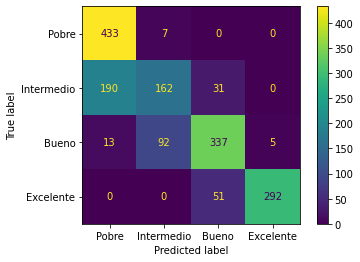

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

target_names_n = [0, 1, 2, 3]

cm = confusion_matrix(y_test, y_test_pred, labels=target_names_n)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=target_names)
disp.plot()
plt.savefig(res_path + "cm.png")
plt.show()